In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

# GAN

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(200):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

[Epoch 0/200] [Batch 0/938] [D loss: 0.688895] [G loss: 0.724274]


The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.337322] [G loss: 1.744197]
[Epoch 194/200] [Batch 629/938] [D loss: 0.310429] [G loss: 1.418820]
[Epoch 194/200] [Batch 630/938] [D loss: 0.270184] [G loss: 1.706868]
[Epoch 194/200] [Batch 631/938] [D loss: 0.230464] [G loss: 2.665611]
[Epoch 194/200] [Batch 632/938] [D loss: 0.299471] [G loss: 2.510353]
[Epoch 194/200] [Batch 633/938] [D loss: 0.311059] [G loss: 1.810890]
[Epoch 194/200] [Batch 634/938] [D loss: 0.307054] [G loss: 1.537281]
[Epoch 194/200] [Batch 635/938] [D loss: 0.246767] [G loss: 2.038338]
[Epoch 194/200] [Batch 636/938] [D loss: 0.230069] [G loss: 2.332350]
[Epoch 194/200] [Batch 637/938] [D loss: 0.190375] [G loss: 2.151009]
[Epoch 194/200] [Batch 638/938] [D loss: 0.367538] [G loss: 2.342012]
[Epoch 194/200] [Batch 639/938] [D loss: 0.261238] [G loss: 2.137904]
[Epoch 194/200] [Batch 640/938] [D loss: 0.294867] [G loss: 1.956728]
[Epoch 194/200] [Batch 641/938] [D loss

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-generator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-discriminator.pth')

# GAN with Noise

In [ ]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.05, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class GeneratorN(nn.Module):
    def __init__(self):
        super(GeneratorN, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class DiscriminatorN(nn.Module):
    def __init__(self, std=0.1, std_decay_rate=0):
        super(DiscriminatorN, self).__init__()
        self.std = std
        self.std_decay_rate = std_decay_rate

        self.model = nn.Sequential(
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            GaussianNoise(self.std, self.std_decay_rate),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = GeneratorN()
discriminator = DiscriminatorN()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(200):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.252794] [G loss: 2.064144]
[Epoch 194/200] [Batch 629/938] [D loss: 0.288948] [G loss: 2.144348]
[Epoch 194/200] [Batch 630/938] [D loss: 0.236427] [G loss: 1.580507]
[Epoch 194/200] [Batch 631/938] [D loss: 0.234243] [G loss: 2.166021]
[Epoch 194/200] [Batch 632/938] [D loss: 0.280206] [G loss: 2.309424]
[Epoch 194/200] [Batch 633/938] [D loss: 0.247585] [G loss: 2.046830]
[Epoch 194/200] [Batch 634/938] [D loss: 0.233540] [G loss: 2.224597]
[Epoch 194/200] [Batch 635/938] [D loss: 0.218530] [G loss: 2.137791]
[Epoch 194/200] [Batch 636/938] [D loss: 0.262321] [G loss: 2.400455]
[Epoch 194/200] [Batch 637/938] [D loss: 0.275865] [G loss: 2.028315]
[Epoch 194/200] [Batch 638/938] [D loss: 0.280239] [G loss: 2.185139]
[Epoch 194/200] [Batch 639/938] [D loss: 0.236333] [G loss: 1.801018]
[Epoch 194/200] [Batch 640/938] [D loss: 0.390258] [G loss: 2.924680]
[Epoch 194/200] [Batch 641/938] [D loss

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


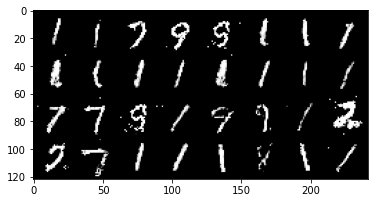

In [ ]:
show(gen_imgs)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-ngenerator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-ndiscriminator.pth')

# GAN with geodesic loss

In [ ]:
img_shape = (1, 28, 28)

cuda = True if torch.cuda.is_available() else False

class GeneratorG(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class DiscriminatorG(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


In [ ]:
def riemannian_loss(output, target):
    

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(200):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

[Epoch 0/200] [Batch 0/938] [D loss: 0.688895] [G loss: 0.724274]


The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


Streaming output truncated to the last 5000 lines.
[Epoch 194/200] [Batch 628/938] [D loss: 0.337322] [G loss: 1.744197]
[Epoch 194/200] [Batch 629/938] [D loss: 0.310429] [G loss: 1.418820]
[Epoch 194/200] [Batch 630/938] [D loss: 0.270184] [G loss: 1.706868]
[Epoch 194/200] [Batch 631/938] [D loss: 0.230464] [G loss: 2.665611]
[Epoch 194/200] [Batch 632/938] [D loss: 0.299471] [G loss: 2.510353]
[Epoch 194/200] [Batch 633/938] [D loss: 0.311059] [G loss: 1.810890]
[Epoch 194/200] [Batch 634/938] [D loss: 0.307054] [G loss: 1.537281]
[Epoch 194/200] [Batch 635/938] [D loss: 0.246767] [G loss: 2.038338]
[Epoch 194/200] [Batch 636/938] [D loss: 0.230069] [G loss: 2.332350]
[Epoch 194/200] [Batch 637/938] [D loss: 0.190375] [G loss: 2.151009]
[Epoch 194/200] [Batch 638/938] [D loss: 0.367538] [G loss: 2.342012]
[Epoch 194/200] [Batch 639/938] [D loss: 0.261238] [G loss: 2.137904]
[Epoch 194/200] [Batch 640/938] [D loss: 0.294867] [G loss: 1.956728]
[Epoch 194/200] [Batch 641/938] [D loss

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-generator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-discriminator.pth')

# CGAN

In [ ]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100 + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod((1, 28, 28)))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *(1, 28, 28))
        return img


class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod((1, 28, 28))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
cuda = True if torch.cuda.is_available() else False

In [ ]:
# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = CGenerator()
discriminator = CDiscriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=64,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [ ]:
for epoch in range(100):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, 100))))
        gen_labels = Variable(LongTensor(np.random.randint(0, 10, batch_size)))

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, 200, i, len(dataloader), d_loss.item(), g_loss.item())
        )

Streaming output truncated to the last 5000 lines.
[Epoch 94/200] [Batch 628/938] [D loss: 0.255712] [G loss: 0.276666]
[Epoch 94/200] [Batch 629/938] [D loss: 0.244675] [G loss: 0.256369]
[Epoch 94/200] [Batch 630/938] [D loss: 0.251282] [G loss: 0.264487]
[Epoch 94/200] [Batch 631/938] [D loss: 0.254645] [G loss: 0.254775]
[Epoch 94/200] [Batch 632/938] [D loss: 0.252010] [G loss: 0.239296]
[Epoch 94/200] [Batch 633/938] [D loss: 0.240175] [G loss: 0.264433]
[Epoch 94/200] [Batch 634/938] [D loss: 0.239914] [G loss: 0.290172]
[Epoch 94/200] [Batch 635/938] [D loss: 0.250478] [G loss: 0.275930]
[Epoch 94/200] [Batch 636/938] [D loss: 0.241898] [G loss: 0.262876]
[Epoch 94/200] [Batch 637/938] [D loss: 0.244349] [G loss: 0.254754]
[Epoch 94/200] [Batch 638/938] [D loss: 0.245142] [G loss: 0.231997]
[Epoch 94/200] [Batch 639/938] [D loss: 0.254367] [G loss: 0.236713]
[Epoch 94/200] [Batch 640/938] [D loss: 0.246590] [G loss: 0.242585]
[Epoch 94/200] [Batch 641/938] [D loss: 0.236027] [G

In [ ]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def show(imgs):
    grid = vutils.make_grid(imgs.cpu())
    plt.imshow(grid.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


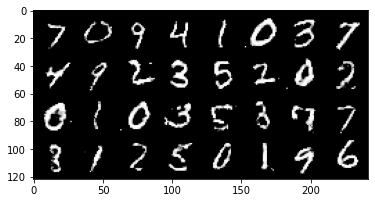

In [ ]:
show(gen_imgs)

In [ ]:
torch.save(generator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth')

In [ ]:
torch.save(discriminator.state_dict(), '/content/drive/My Drive/explainable-gan/mnist-cdiscriminator.pth')

# Explainable

In [ ]:
device = torch.device("cuda:0")

In [ ]:
netG = Generator()
# netCG = CGenerator()

In [ ]:
netG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-generator.pth'))
# netCG.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cgenerator.pth'))

<All keys matched successfully>

In [ ]:
netD = Discriminator()
# netCD = CDiscriminator()

In [ ]:
netD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-discriminator.pth'))
# netCD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cdiscriminator.pth'))

<All keys matched successfully>

In [ ]:
netD.to(device)
# netCD.to(device)
netG.to(device)
# netCG.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
!pip install captum

     |████████████████████████████████| 1.4 MB 9.9 MB/s 


In [ ]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import Lime
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import DeepLiftShap

## Normal GAN

In [ ]:
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
dl = DeepLiftShap(netD)

5


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


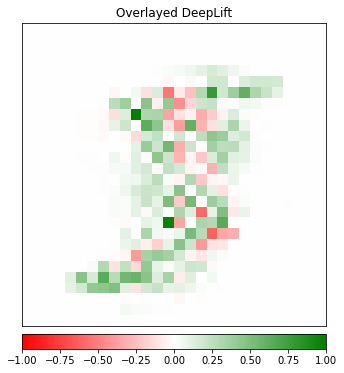

0


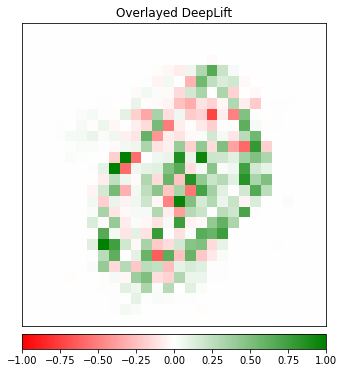

4


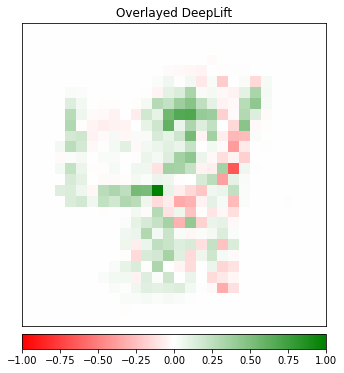

1


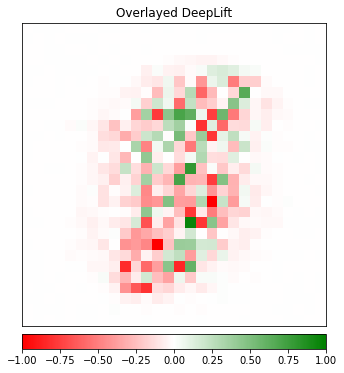

9


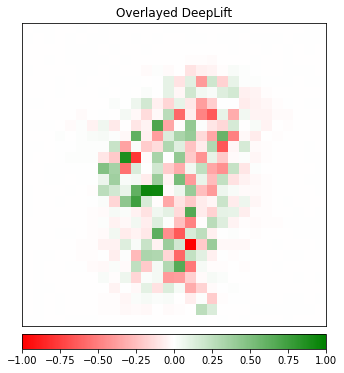

2


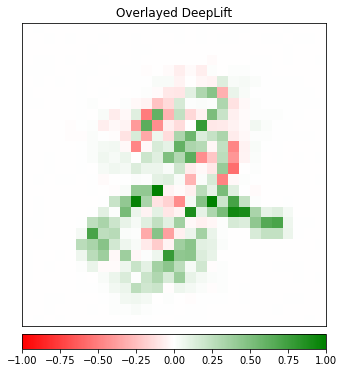

3


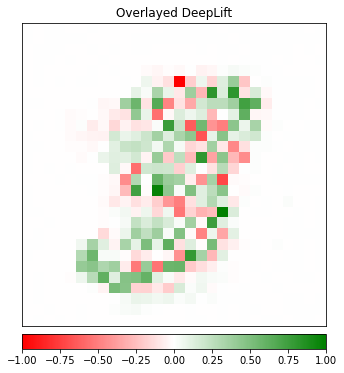

6


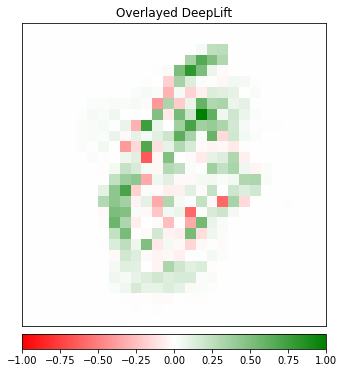

7


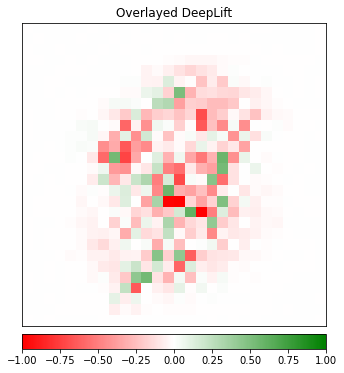

8


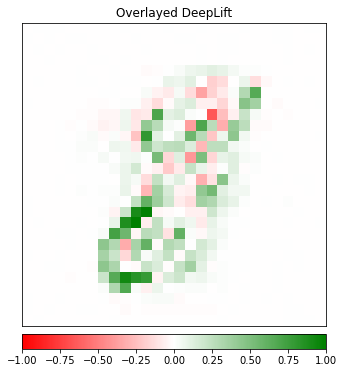

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = dl.attribute(input.to(device), baselines=fakes, target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="DeepListSHAP")

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
dl = DeepLiftShap(netD)

5


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


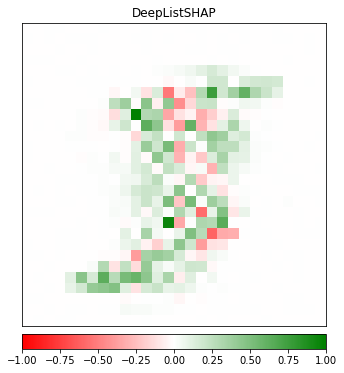

0


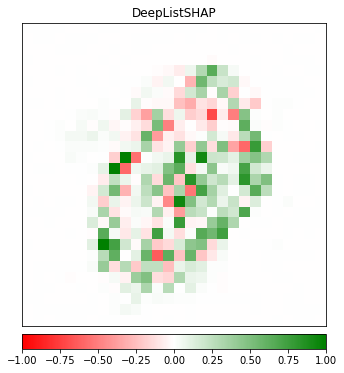

4


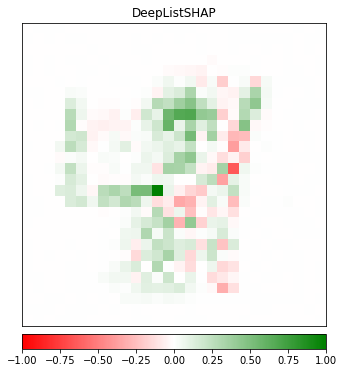

1


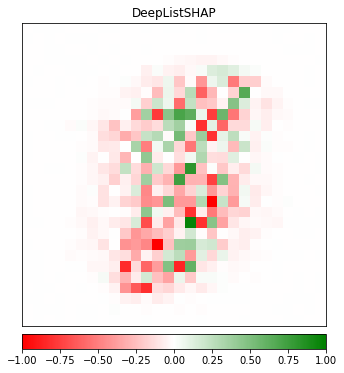

9


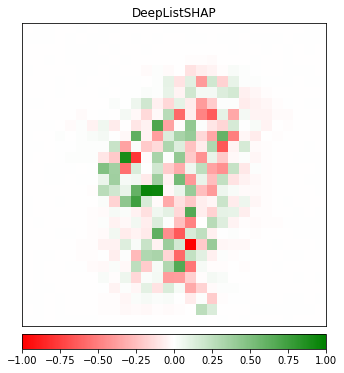

2


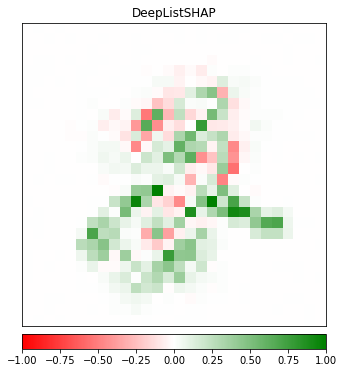

3


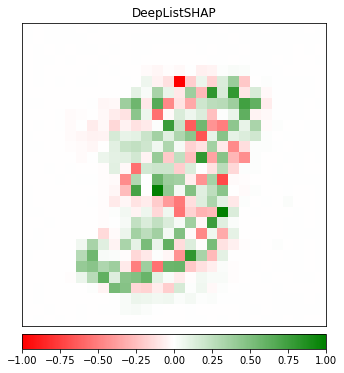

6


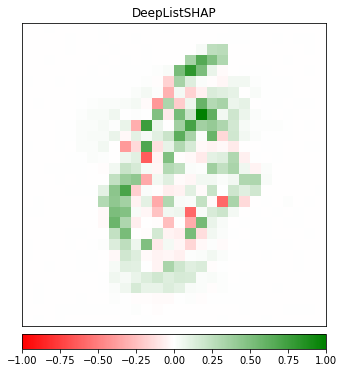

7


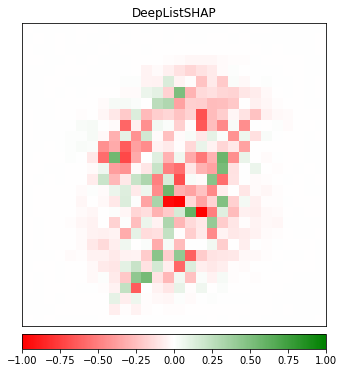

8


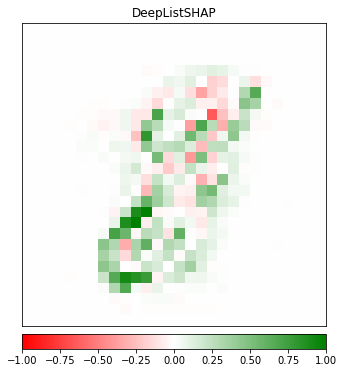

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = dl.attribute(input.to(device), baselines=fakes, target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="DeepListSHAP")

### Integrated gradient

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
ig = IntegratedGradients(netD)

5


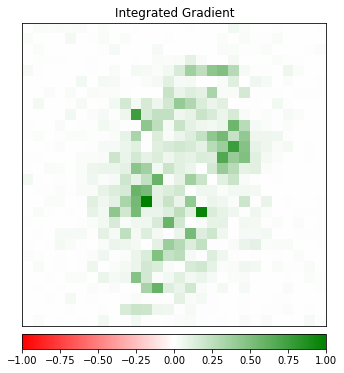

0


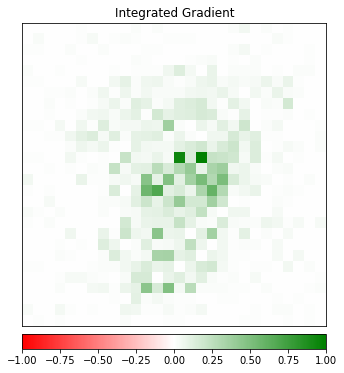

4


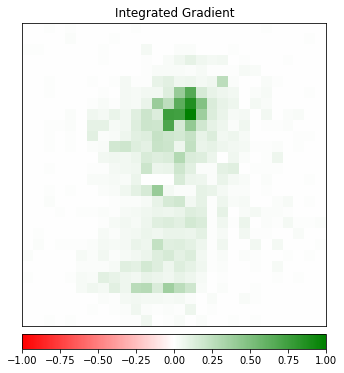

1


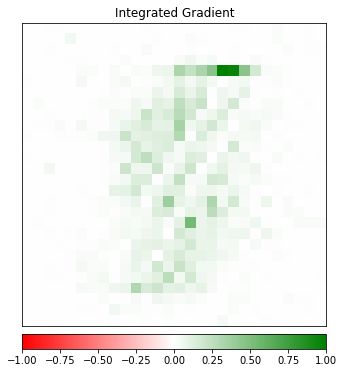

9


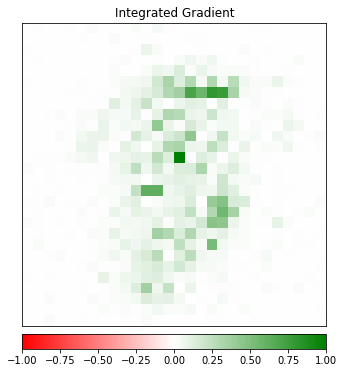

2


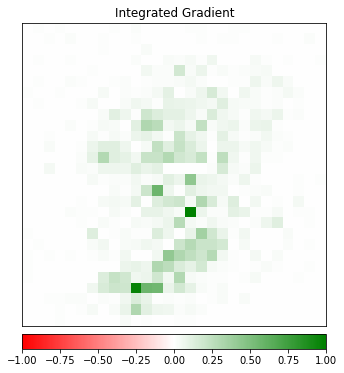

3


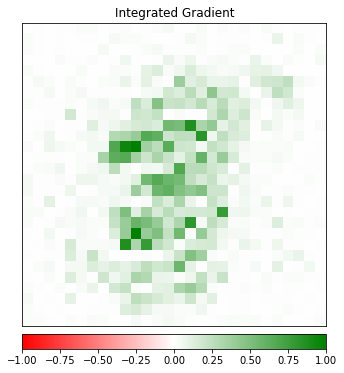

6


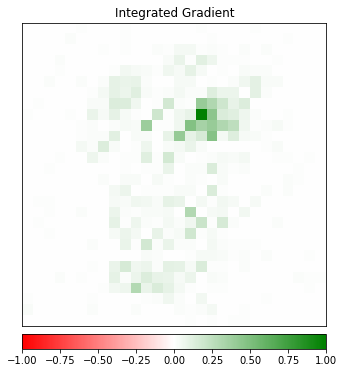

7


/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


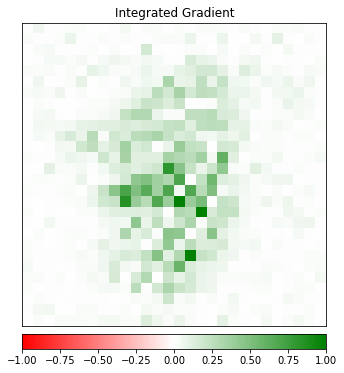

8


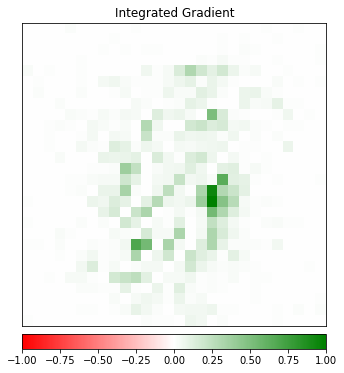

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    baseline = input * 0
    nt = NoiseTunnel(ig)
    attr_dl = nt.attribute(input.to(device), baselines=baseline.to(device), target=None, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Integrated Gradient")

### LIME

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
fakes.shape

NameError: ignored

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
from captum._utils.models.linear_model import SkLearnLasso

In [ ]:
ig = Lime(netD, interpretable_model=SkLearnLasso(alpha=0.0))

5


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


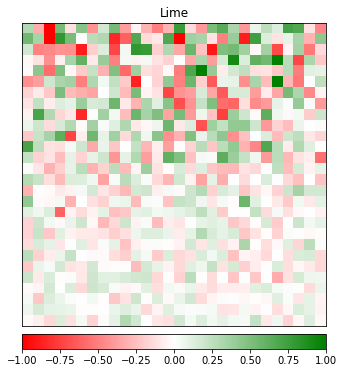

0


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


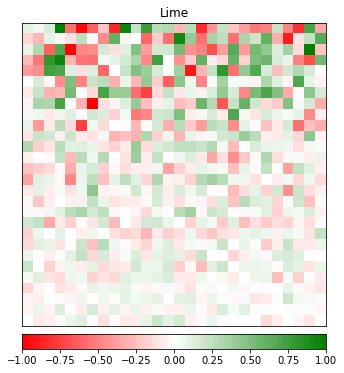

4


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


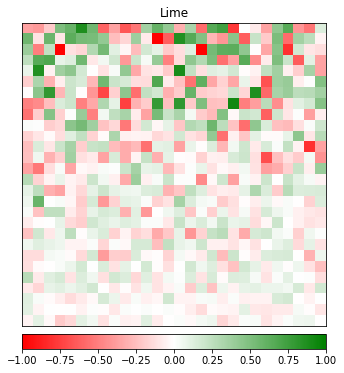

1


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


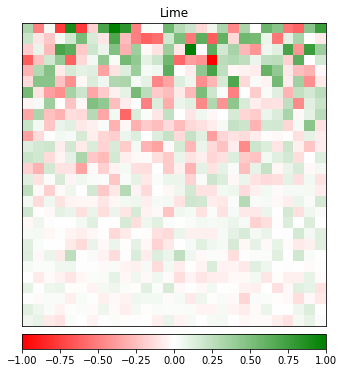

9


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


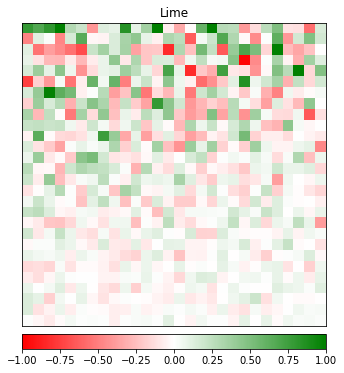

2


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


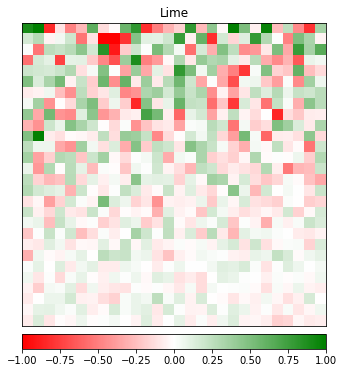

3


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


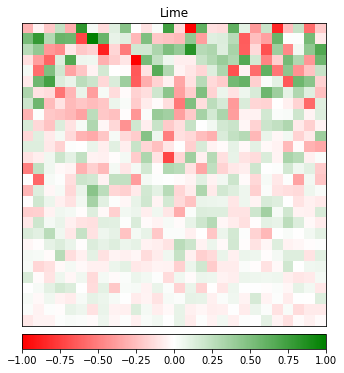

6


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


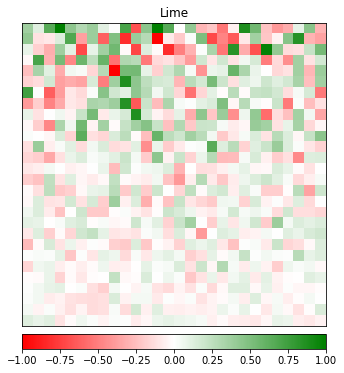

7


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


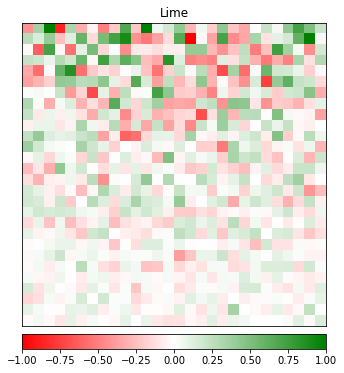

8


/usr/local/lib/python3.7/dist-packages/captum/_utils/models/linear_model/train.py:328: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  sklearn_model.fit(x, y, sample_weight=w, **fit_kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


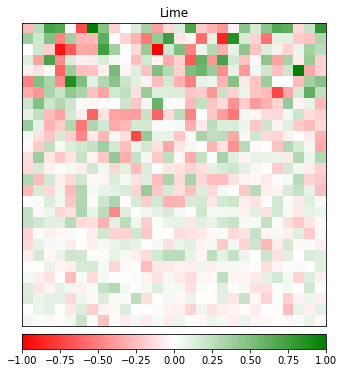

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0).to(device)
    attr = ig.attribute(input, target=None, n_samples=200)
    attr_dl = np.transpose(attr.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Lime")

In [ ]:
attr_dl

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
  

### Deeplift

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = netG(z)

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
ig = DeepLift(netD)

5


/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:323: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


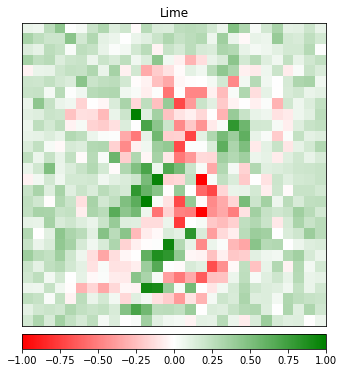

0


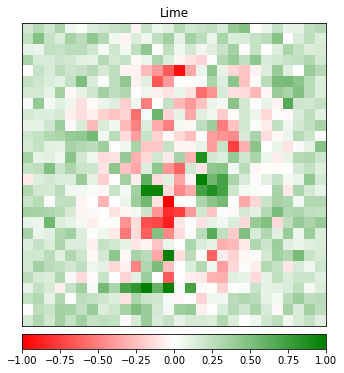

4


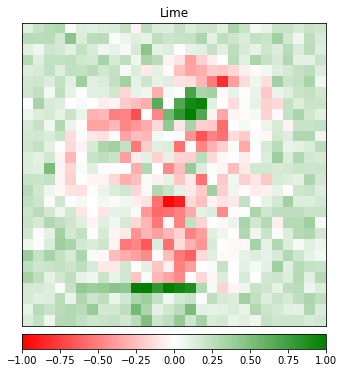

1


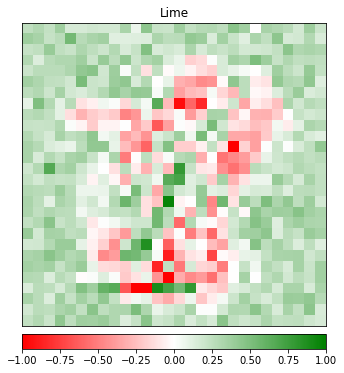

9


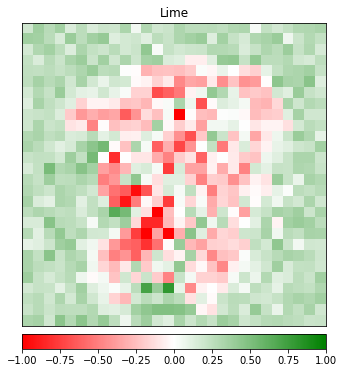

2


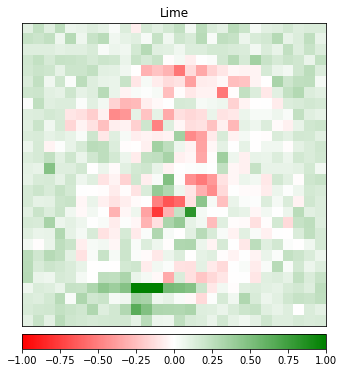

3


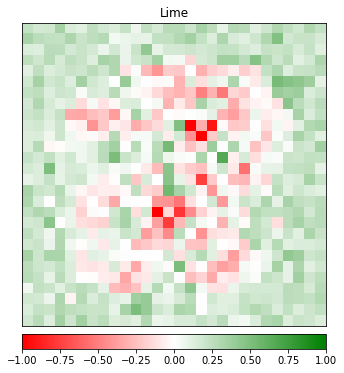

6


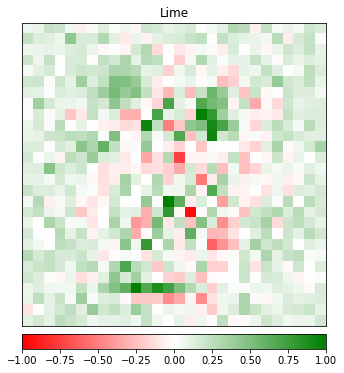

7


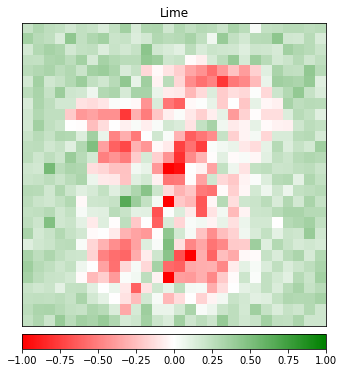

8


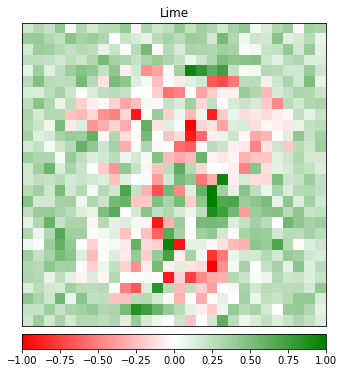

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = ig.attribute(input.to(device), target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Lime")

## GAN with noise

In [ ]:
os.makedirs("./data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)

### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
fakes = generator(z)

In [ ]:
dataiter = iter(dataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
for idx, (imgs, _) in enumerate(dataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([4100, 1, 28, 28])

In [ ]:
dl = DeepLiftShap(discriminator)

1


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


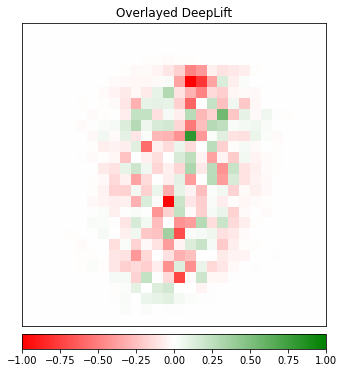

6


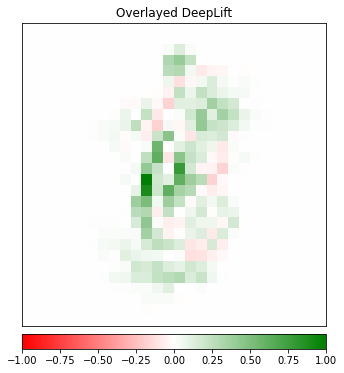

7


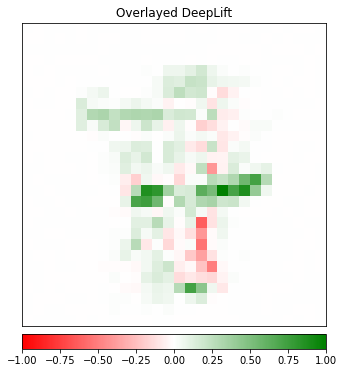

0


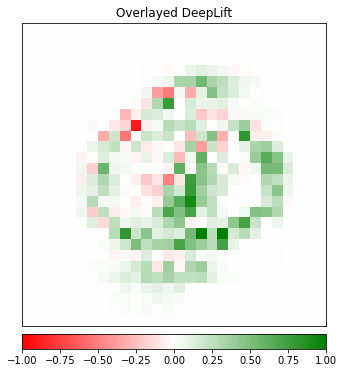

4


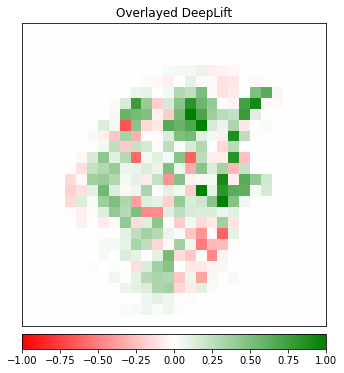

2


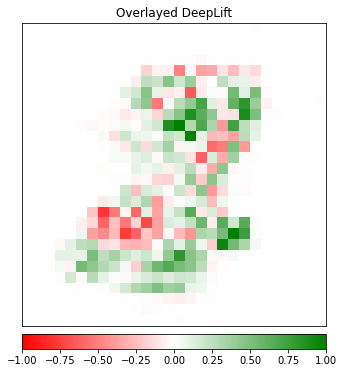

9


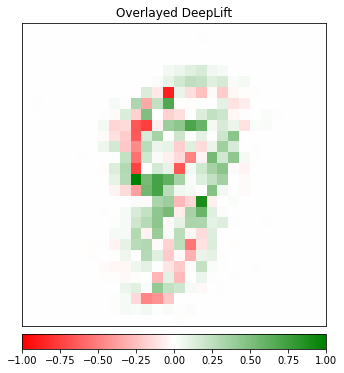

8


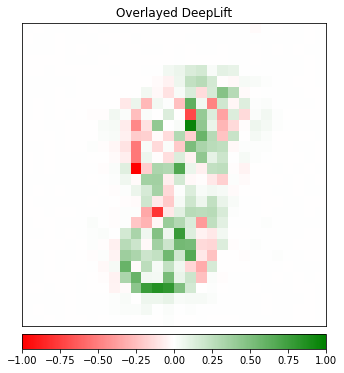

3


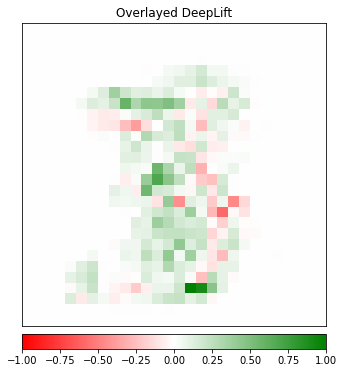

5


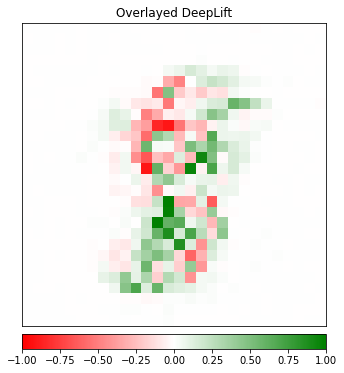

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    input = img.unsqueeze(0)
    attr_dl = dl.attribute(input.to(device), baselines=fakes, target=None)
    attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                            title="Overlayed DeepLift")

## CGAN

In [ ]:
os.makedirs("./data/mnist", exist_ok=True)
cdataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(28), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=100,
    shuffle=False,
)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod((1, 28, 28))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, d_in):
        # Concatenate label embedding and image to produce input
        validity = self.model(d_in)
        return validity

In [ ]:
netCD = CDiscriminator()

In [ ]:
netCD

CDiscriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
netCD.load_state_dict(torch.load('/content/drive/My Drive/explainable-gan/mnist-cdiscriminator.pth'))

<All keys matched successfully>

In [ ]:
netCD.to(device)

CDiscriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### Deeplift SHAP

In [ ]:
z = Variable(torch.Tensor(np.random.normal(0, 1, (2500, 100))))

In [ ]:
z = z.to(device)

In [ ]:
z

tensor([[-0.6046,  2.1251,  0.2168,  ..., -1.1715, -1.4294, -1.1409],
        [ 0.6940, -2.3700, -0.0571,  ..., -1.4351,  1.0444, -2.0569],
        [ 1.6241, -0.1642, -0.0253,  ..., -0.3592,  0.2700,  0.1758],
        ...,
        [-0.5479,  2.1160, -0.8386,  ..., -1.5032, -0.6759, -1.2178],
        [ 0.5716,  0.7276, -0.2680,  ...,  0.4940, -0.9408, -0.8915],
        [-1.0733, -0.6625, -1.1666,  ...,  0.8782, -0.2945,  2.1288]],
       device='cuda:0')

In [ ]:
fake_labels = torch.full((250,), 0)
for i in range(1, 10):
    fake_labels = torch.cat((fake_labels, torch.full((250,), i)))

In [ ]:
fake_labels = fake_labels.to(device)

In [ ]:
fakes = netCG(z, fake_labels)

In [ ]:
dataiter = iter(cdataloader)
images, labels = dataiter.next()

In [ ]:
real_images = []
label_sets = set()
real_labels = []

In [ ]:
for idx, img in enumerate(images):
    if labels[idx].item() not in label_sets:
        real_images.append(img)
        label_sets.add(labels[idx].item())
        real_labels.append(labels[idx].item())

In [ ]:
fakes.shape

torch.Size([2500, 1, 28, 28])

In [ ]:
fake_labels.shape

torch.Size([2500])

In [ ]:
for idx, (imgs, labels) in enumerate(cdataloader):
    if (idx < 25):
        fakes = torch.cat((fakes, imgs.to(device)), axis=0)
        fake_labels = torch.cat((fake_labels, labels.to(device)), axis=0)
    else:
        break

In [ ]:
fakes.shape

torch.Size([5000, 1, 28, 28])

In [ ]:
fake_labels.shape

torch.Size([5000])

In [ ]:
dl = DeepLiftShap(netCD)

In [ ]:
torch.LongTensor([5])

tensor([5])

In [ ]:
combined = torch.cat((fakes.view(fakes.size(0), -1), netCD.label_embedding(fake_labels)), -1)

In [ ]:
combined.shape

torch.Size([5000, 794])

In [ ]:
combined.device

device(type='cuda', index=0)

5
[ 0.02608948  0.04225932 -0.01091546 -0.06298771  0.00744745 -0.02519951
 -0.03244716  0.03956501  0.00243982 -0.0089197 ]


/usr/local/lib/python3.7/dist-packages/captum/attr/_core/deep_lift.py:325: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


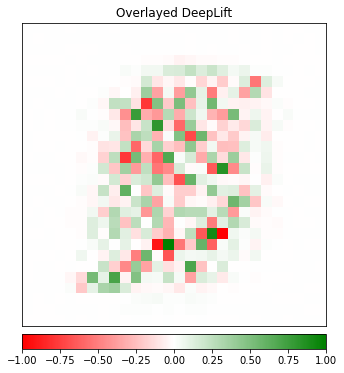

0
[-0.00721577 -0.00571428 -0.01879768 -0.05056351 -0.00859838  0.02087663
  0.00616469  0.0556007   0.00135365  0.00328526]


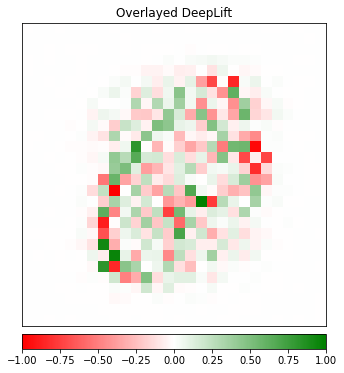

4
[ 0.11059003 -0.12688357 -0.03244441  0.00390435  0.03090592  0.00102633
  0.01852031 -0.03622628 -0.00045516 -0.01238829]


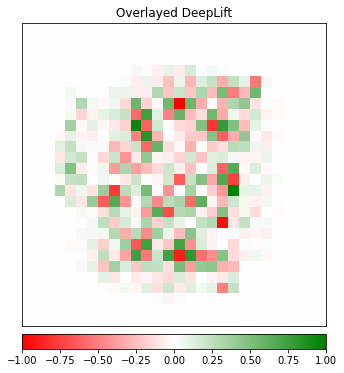

1
[-0.03853973  0.05861174  0.03935844 -0.08503781  0.01661537  0.03131365
 -0.00382785  0.02455166 -0.00082221 -0.0137993 ]


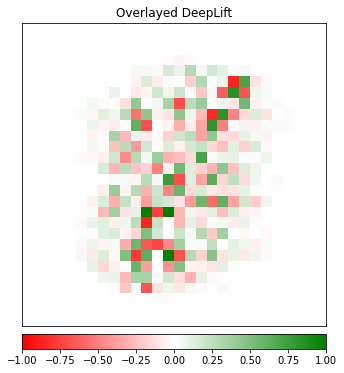

9
[ 0.0193216  -0.06786215  0.02229902  0.0730989  -0.06245354  0.00810961
  0.00267861 -0.00176514 -0.00030277  0.0013913 ]


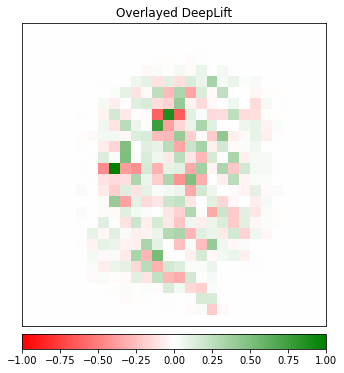

2
[-0.02138226  0.1170447   0.05654698 -0.09319866 -0.02467977 -0.03941201
  0.01382227 -0.01735785  0.00183909  0.00280169]


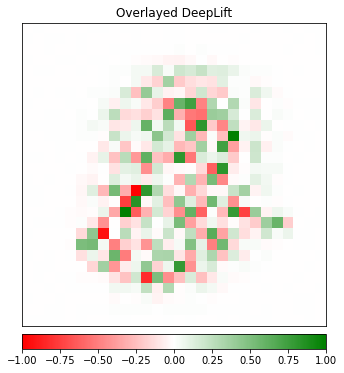

3
[ 0.05493468  0.01926423  0.02775698 -0.04202111  0.01040917  0.00746306
 -0.00734737 -0.06865036  0.00390113  0.00439066]


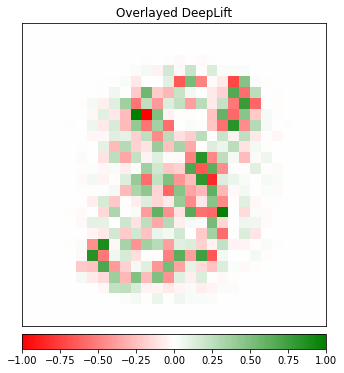

6
[-0.01745588 -0.10325363  0.03986767  0.10113261  0.00325276 -0.001741
  0.00235844 -0.03082437 -0.0061814  -0.00171225]


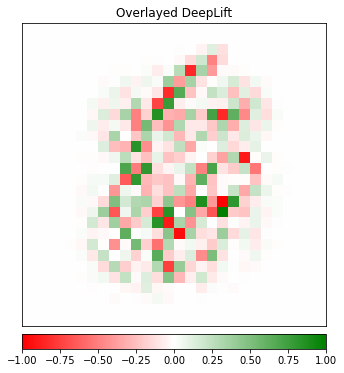

7
[ 0.00827129  0.04434726 -0.09689658  0.10703923 -0.01782497 -0.00619386
  0.00218693 -0.03090206  0.00123796  0.00020687]


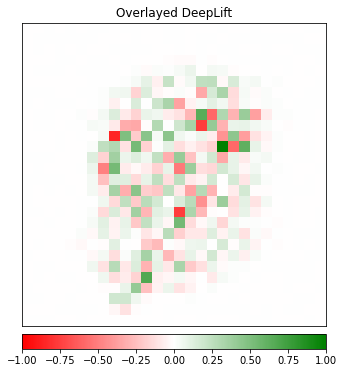

8
[-0.12920217 -0.02014331 -0.01162779  0.04677437  0.04578998 -0.01299678
 -0.01677275  0.05321196 -0.01323899  0.00761188]


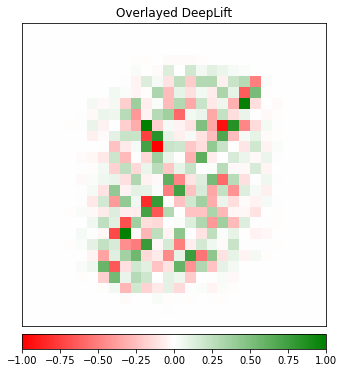

In [ ]:
for idx, img in enumerate(real_images):
    print(real_labels[idx])
    label = torch.LongTensor([real_labels[idx]])
    label = label.to(device)
    img = img.to(device)
    d_in = torch.cat((img.view(img.size(0), -1), netCD.label_embedding(label)), -1)
    attr_dl = dl.attribute(d_in, baselines=combined, target=None)
    print(attr_dl[0, 784:].cpu().detach().numpy())
    attr_dl = attr_dl[0, :784].cpu().detach().numpy().reshape(28, 28, 1)
    original_image = np.transpose((img.cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
    _ = viz.visualize_image_attr(attr_dl, method="heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")